In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.style as mplstyle
import datetime
import statistics


#for list of style plt.style.available (https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#mplstyle.use('bmh')

In [6]:
customer_profiles_df=pd.read_csv("./data/customer_profiles_table.csv")
transactions_df=pd.read_csv("./data/transactions_df.csv", parse_dates=["TX_DATETIME"])
terminal_profiles_df=pd.read_csv("./data/terminal_profiles_table.csv")

# Exploratory data analysis

This project will use a data set generator created by [Yann-Aël Le Borgne & Gianluca Bontempi](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html). The generator will create three dataset that reproduce the logs of a fictional card company, including fraudulent transactions. 

The logs are split in three dataset, column name in lower case are directly linked to the main dataset **transactions_df**:

1 - Customer profile

| Column | Type | Description |
| --- | --- | --- |
| CUSTOMER_ID | int64 | The customer unique ID|
|(x_customer_id,y_customer_id) | float64 | A pair of real coordinates (x_customer_id,y_customer_id) in a 100 * 100 grid, that defines the geographical location of the customer |
|(mean_amount, std_amount) | float64 | The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.|
| mean_nb_tx_per_day | float64 | The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4) |

The generate_customer_profiles_table function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer.

In [7]:
customer_profiles_df.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",78
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[5, 160, 242, 378, 431, 475, 571, 762, 876, 93...",85
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[316, 406, 447, 523, 968, 1200, 1318, 1365, 16...",70
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[65, 94, 113, 364, 401, 433, 485, 651, 672, 77...",70
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[372, 614, 774, 1362, 1446, 1564, 1637, 1939, ...",65


In [8]:
customer_profiles_df.shape

(5000, 8)

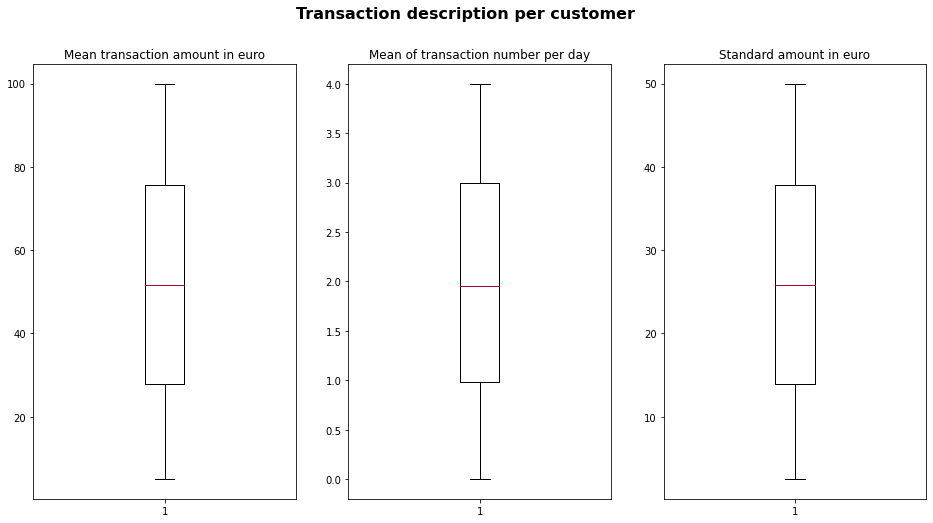

In [9]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
mplstyle.use('bmh')
fig.suptitle("Transaction description per customer", fontsize=16, fontweight='bold')

ax[0].boxplot(customer_profiles_df["mean_amount"])
ax[1].boxplot(customer_profiles_df["mean_nb_tx_per_day"])
ax[2].boxplot(customer_profiles_df["std_amount"])

ax[0].title.set_text("Mean transaction amount in euro")
ax[1].title.set_text("Mean of transaction number per day")
ax[2].title.set_text("Standard amount in euro")


plt.show()

2 - Terminal profile

| Column | Type | Description |
| --- | --- | --- |
| TERMINAL_ID | int64 | The terminal ID|
| (x_terminal_id,y_terminal_id) | float64 | A pair of real coordinates (x_terminal_id,y_terminal_id) in a 100 * 100 grid, that defines the geographical location of the terminal|

The generate_terminal_profiles_table function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal.

In [10]:
terminal_profiles_df.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673


In [11]:
terminal_profiles_df.shape

(10000, 3)

3 - Transaction list


| Column | Type | Description |
| --- | --- | --- |
| TRANSACTION_ID  | int64 | A unique identifier for the transaction|
| TX_DATETIME  | object | Date and time at which the transaction occurs|
| CUSTOMER_ID  | int64 | The identifier for the customer. Each customer has a unique identifier|
| TERMINAL_ID  | int64 | The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier|
| TX_AMOUNT	  | int64 | The amount of the transaction|
| TX_FRAUD  | int64 | A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction|
| TX_FRAUD_SCENARIO | int64 | Referencing the fraud scenario, 0 indicate a genuine transaction|

* Fraud scenario:

Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. 

Scenario 2: Every day, a list of 6 terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. 

Scenario 3: Every day, a list of 6 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. 

Scenario 4 : Every day a list of 4 customer is drawn at random. In the next 3 days every transaction have their amount multiplied by a random number between 3 and 6. This scenario simulate a hit and run scenario where fraudster try to exit as much funds as possible before being detected.

In [12]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [13]:
#Fraud repartition

transactions_df_temp = transactions_df.groupby("TX_FRAUD_SCENARIO").count()
transactions_df_temp["percentage"] = (transactions_df_temp[["TX_FRAUD"]]/
                                      transactions_df_temp[["TX_FRAUD"]].sum())*100
transactions_df_temp[["TX_FRAUD","percentage"]]

,TX_FRAUD,percentage
TX_FRAUD_SCENARIO,,
0,1738126,99.086227
1,972,0.055411
2,9067,0.516887
3,3907,0.222728
4,2083,0.118747


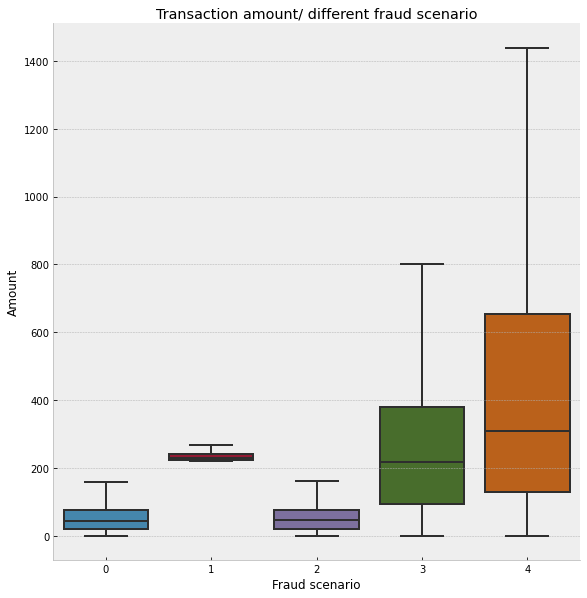

In [14]:
sns.displot(color = "rocket", height=8)

ax = sns.boxplot(x = "TX_FRAUD_SCENARIO",y = "TX_AMOUNT", data= transactions_df, showfliers = False)
ax.set_title("Transaction amount/ different fraud scenario")
ax.set_ylabel("Amount")
ax.set_xlabel("Fraud scenario");

In [15]:
#convert the transactions_df.TX_DATETIME column to a mor
pop = pd.to_datetime(transactions_df["TX_DATETIME"], format='%Y, %m, %d').dt.date
transactions_df_temp = transactions_df
transactions_df_temp["temp_date"] = pop

In [16]:
scn_0 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 0]
scn_1 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 1]
scn_2 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 2]
scn_3 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 3]
scn_4 = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO == 4]
scn_fraud = transactions_df_temp[transactions_df_temp.TX_FRAUD_SCENARIO != 0]

In [17]:
temp_0_sum = scn_0.resample("d", on="TX_DATETIME").sum()
temp_1_sum = scn_1.resample("d", on="TX_DATETIME").sum()
temp_2_sum = scn_2.resample("d", on="TX_DATETIME").sum()
temp_3_sum = scn_3.resample("d", on="TX_DATETIME").sum()
temp_4_sum = scn_4.resample("d", on="TX_DATETIME").sum()
temp_fraud_sum = scn_fraud.resample("d", on="TX_DATETIME").sum()

temp_0_count = scn_0.resample("d", on="TX_DATETIME").count()
temp_1_count = scn_1.resample("d", on="TX_DATETIME").count()
temp_2_count = scn_2.resample("d", on="TX_DATETIME").count()
temp_3_count = scn_3.resample("d", on="TX_DATETIME").count()
temp_4_count = scn_4.resample("d", on="TX_DATETIME").count()
temp_fraud_count = scn_fraud.resample("d", on="TX_DATETIME").sum()

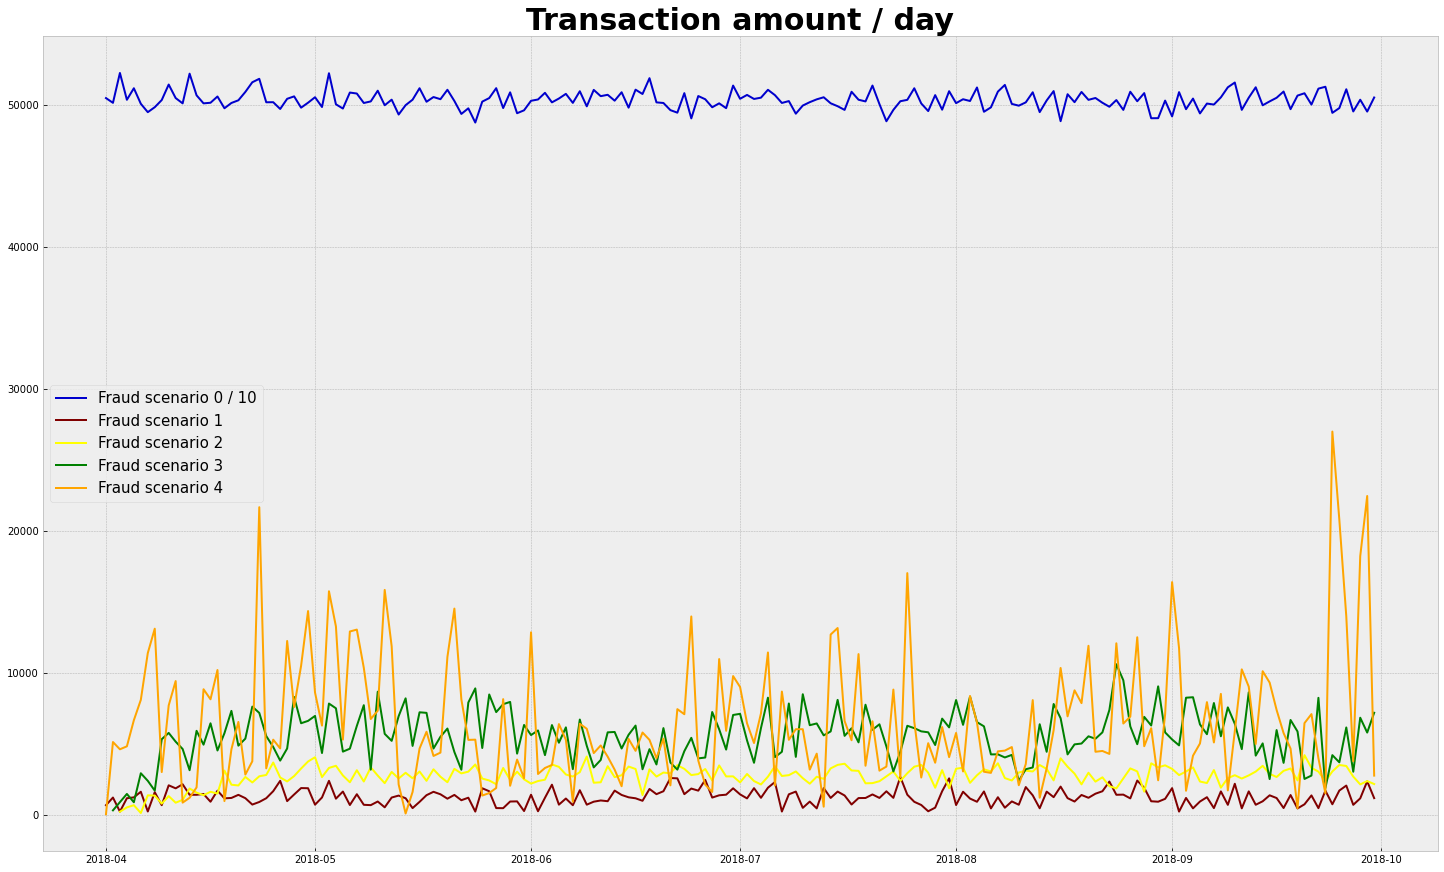

In [18]:
fig, ax=plt.subplots(figsize=(25, 15))
mplstyle.use('bmh')
plt.plot(temp_0_sum.index  , (temp_0_sum.TX_AMOUNT/10),label="Fraud scenario 0 / 10", color = "mediumblue")
plt.plot(temp_1_sum.index, temp_1_sum.TX_AMOUNT,label="Fraud scenario 1",color = "maroon")
plt.plot(temp_2_sum.index, temp_2_sum.TX_AMOUNT,label="Fraud scenario 2",color = "yellow")
plt.plot(temp_3_sum.index, temp_3_sum.TX_AMOUNT,label="Fraud scenario 3",color = "green")
plt.plot(temp_4_sum.index, temp_4_sum.TX_AMOUNT,label="Fraud scenario 4",color ="orange")

plt.title("Transaction amount / day", fontsize=30, fontweight='bold')
ax.legend(fontsize=15)
plt.show()

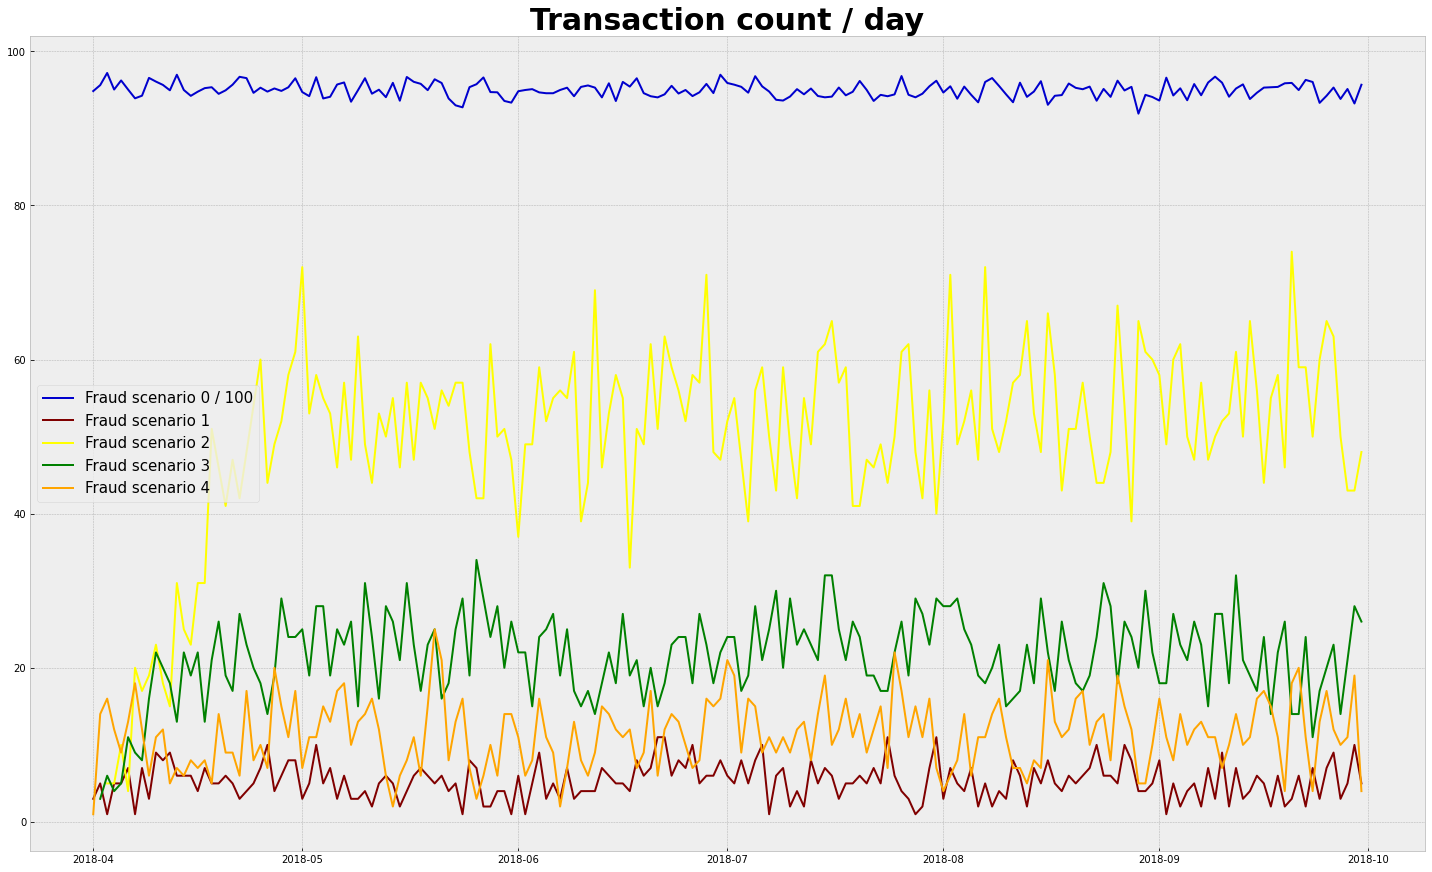

In [19]:
fig, ax=plt.subplots(figsize=(25, 15))


plt.plot(temp_0_count.index, (temp_0_count.TX_AMOUNT/100),label="Fraud scenario 0 / 100", color = "mediumblue")
plt.plot(temp_1_count.index, temp_1_count.TX_AMOUNT,label="Fraud scenario 1",color = "maroon")
plt.plot(temp_2_count.index, temp_2_count.TX_AMOUNT,label="Fraud scenario 2",color = "yellow")
plt.plot(temp_3_count.index, temp_3_count.TX_AMOUNT,label="Fraud scenario 3",color = "green")
plt.plot(temp_4_count.index, temp_4_count.TX_AMOUNT,label="Fraud scenario 4",color ="orange")

plt.title("Transaction count / day", fontsize=30, fontweight='bold')
ax.legend(fontsize=15)
plt.show()

# Dataframe transformation

In [20]:
from datetime import datetime

#date transaformation
# could be optimised
def func_date_monday (data1):
  
    if data1.weekday() == 0:
        return 1
    else:
        return 0
    
def func_date_tuesday (data1):
   
    if data1.weekday() == 1:
        return 1
    else:
        return 0

def func_date_wednesday (data1):
    
    if data1.weekday() == 2:
        return 1
    else:
        return 0
def func_date_thursday (data1):
    
    if data1.weekday() == 3:
        return 1
    else:
        return 0
def func_date_friday (data1):
   
    if data1.weekday() == 4:
        return 1
    else:
        return 0
def func_date_saturday (data1):
    
    if data1.weekday() == 5:
        return 1
    else:
        return 0
def func_date_sunday (data1):
   
    if data1.weekday() == 6:
        return 1
    else:
        return 0

In [21]:
# could be optimised
transactions_df["is_monday"]=transactions_df.TX_DATETIME.apply(func_date_monday);
transactions_df["is_tuesday"]=transactions_df.TX_DATETIME.apply(func_date_tuesday);
transactions_df["is_wednesday"]=transactions_df.TX_DATETIME.apply(func_date_wednesday);
transactions_df["is_thursday"]=transactions_df.TX_DATETIME.apply(func_date_thursday);
transactions_df["is_friday"]=transactions_df.TX_DATETIME.apply(func_date_friday);
transactions_df["is_saturday"]=transactions_df.TX_DATETIME.apply(func_date_saturday);
transactions_df["is_sunday"]=transactions_df.TX_DATETIME.apply(func_date_sunday)

In [22]:
def timestamp1(data1):

    if data1.hour <=6:
        return 1
    else:
        return 0
    
def timestamp2(data1):
   
    if data1.hour >6 and data1.hour <= 12:
        return 1
    else:
        return 0
def timestamp3(data1):
  
    if data1.hour >12 and data1.hour <= 18:
        return 1
    else:
        return 0
def timestamp4(data1):
  
    if data1.hour >18:
        return 1
    else:
        return 0

In [23]:
transactions_df["hour_1_4"]=transactions_df.TX_DATETIME.apply(timestamp1)
transactions_df["hour_2_4"]=transactions_df.TX_DATETIME.apply(timestamp2)
transactions_df["hour_3_4"]=transactions_df.TX_DATETIME.apply(timestamp3)
transactions_df["hour_4_4"]=transactions_df.TX_DATETIME.apply(timestamp4)

In [24]:
def tran_hist (temp_tran_id, window_days):
#sort transaction id by date time and reindex the df
    
    transaction_id_temp_df = temp_tran_id.sort_values("TX_DATETIME")
    transaction_id_temp_df.index = transaction_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        sum_tran_period = transaction_id_temp_df["TX_AMOUNT"].rolling(str(period) + "d").sum()
        count_tran_period =transaction_id_temp_df["TX_AMOUNT"].rolling(str(period)+"d").count()
        average_tran_period = sum_tran_period/count_tran_period
        
        transaction_id_temp_df["average_tx_last"+ str(period) + "days"] = average_tran_period
        transaction_id_temp_df["tx_count_over_last"+ str(period) + "days"] = count_tran_period


    return transaction_id_temp_df

In [25]:
# create columns with rolling transaction history 
temp_bis_df=transactions_df.groupby("CUSTOMER_ID").apply(lambda x: tran_hist(x, window_days=[1,7,30]))
temp_bis_df=temp_bis_df.sort_values("TX_TIME_SECONDS").reset_index(drop=True)
transactions_df = temp_bis_df

In [26]:
def terminal_hist (terminal_id, window_days, period_uncertainty = 10):

#sort terminaid by date time and reindex the df
    
    terminal_id_temp_df = terminal_id.sort_values("TX_DATETIME")
    terminal_id_temp_df.index = terminal_id_temp_df["TX_DATETIME"]

#for loop that will sum number of transaction and average amount on defined period for 
    for period in window_days:
        count_genuine_tran_period = terminal_id_temp_df["TX_FRAUD"].rolling(min_periods= period_uncertainty, 
                                                                            window = (str(period) + "d")).count()
        count_fraudulent__tran_period =terminal_id_temp_df["TX_FRAUD"].rolling(str(period)+"d").sum()
        fraud_rate_period = count_fraudulent__tran_period/count_genuine_tran_period
        
        terminal_id_temp_df["average_terminal_fraud_rate_last"+ str(period) + "days"] = fraud_rate_period


    return terminal_id_temp_df

In [27]:
temp_bis_df=transactions_df.groupby("TERMINAL_ID").apply(lambda x: terminal_hist(x, window_days =[15,30]))
temp_bis_df=temp_bis_df.sort_values("TX_TIME_SECONDS").reset_index(drop=True)
transactions_df = temp_bis_df

In [28]:
transactions_df = transactions_df.fillna(0)

In [29]:
transactions_df.sample(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,temp_date,...,hour_3_4,hour_4_4,average_tx_last1days,tx_count_over_last1days,average_tx_last7days,tx_count_over_last7days,average_tx_last30days,tx_count_over_last30days,average_terminal_fraud_rate_last15days,average_terminal_fraud_rate_last30days
1657879,1657879,2018-09-20 20:11:44,3171,7463,56.16,14933504,172,0,0,2018-09-20,...,0,1,56.160000,1.0,47.000000,2.0,45.462222,9.0,0.0,0.0
91814,91814,2018-04-10 13:16:37,1672,276,198.66,825397,9,0,0,2018-04-10,...,1,0,131.923333,6.0,108.232083,24.0,107.605862,29.0,0.0,0.0
1609908,1609908,2018-09-15 21:10:01,1061,3407,37.16,14505001,167,0,0,2018-09-15,...,0,1,53.610000,3.0,86.676667,15.0,91.062083,72.0,0.0,0.0
668112,668112,2018-06-09 14:09:51,4648,5212,32.93,6012591,69,0,0,2018-06-09,...,1,0,45.265000,2.0,38.715263,19.0,41.424643,84.0,0.0,0.0
1652115,1652114,2018-09-20 09:53:59,2811,2421,64.66,14896439,172,0,0,2018-09-20,...,0,0,45.680000,3.0,54.308571,14.0,57.700784,51.0,0.0,0.0
792290,792290,2018-06-22 13:43:32,1884,833,71.22,7134212,82,0,0,2018-06-22,...,1,0,65.290000,5.0,53.880000,21.0,64.212125,80.0,0.0,0.0
68757,68757,2018-04-08 07:24:52,2070,9011,5.33,631492,7,0,0,2018-04-08,...,0,0,6.793333,3.0,7.203889,18.0,7.203889,18.0,0.0,0.0
1517782,1517782,2018-09-06 10:23:47,3815,2792,57.31,13688627,158,0,0,2018-09-06,...,0,0,73.320000,2.0,66.990000,9.0,74.186061,33.0,0.0,0.0
498008,498008,2018-05-22 17:29:25,1640,9223,25.25,4469365,51,0,0,2018-05-22,...,1,0,25.902000,5.0,28.733810,21.0,29.010375,80.0,0.0,0.0
382096,382096,2018-05-10 16:29:21,4257,3395,11.60,3428961,39,0,0,2018-05-10,...,1,0,8.533333,3.0,11.703636,22.0,13.114706,102.0,0.0,0.0


# Machine learning

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X=transactions_df[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days']]  # Features
y=transactions_df['TX_FRAUD'] 

In [32]:
%time X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

CPU times: user 623 ms, sys: 200 ms, total: 823 ms
Wall time: 923 ms


In [33]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
%time clf.fit(X_train,y_train)

%time y_pred=clf.predict(X_test)

CPU times: user 9min 21s, sys: 8.4 s, total: 9min 29s
Wall time: 1min 35s
CPU times: user 2.49 s, sys: 82.6 ms, total: 2.57 s
Wall time: 429 ms


In [34]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
%time print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9982669767866101
CPU times: user 6.31 ms, sys: 1.46 ms, total: 7.77 ms
Wall time: 6.56 ms


In [30]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
%time print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9982156701783189
CPU times: user 6.08 ms, sys: 1.33 ms, total: 7.41 ms
Wall time: 6.36 ms


In [31]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

average_terminal_fraud_rate_last15days    0.294251
average_terminal_fraud_rate_last30days    0.219841
TX_AMOUNT                                 0.218710
average_tx_last1days                      0.091167
average_tx_last7days                      0.060624
average_tx_last30days                     0.047308
tx_count_over_last30days                  0.020442
tx_count_over_last7days                   0.016239
tx_count_over_last1days                   0.010322
hour_2_4                                  0.002515
hour_3_4                                  0.002343
hour_1_4                                  0.001980
is_wednesday                              0.001917
is_saturday                               0.001894
is_thursday                               0.001877
is_monday                                 0.001868
is_sunday                                 0.001789
is_tuesday                                0.001765
is_friday                                 0.001757
hour_4_4                       

No handles with labels found to put in legend.


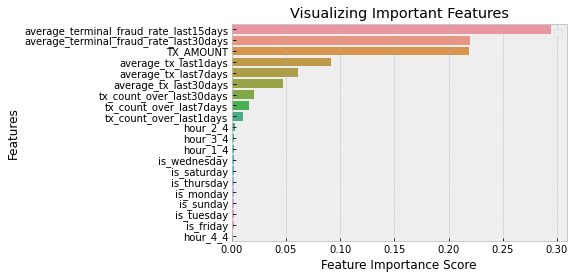

In [32]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

to do later, need too much ressources

#trying to find the best setting

from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rfc=RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = { 
    'n_estimators': [50,75,100,125,150,175,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,15,20,25,30],
    'criterion' :['gini', 'entropy']
}

%time CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)



%time CV_rfc.fit(X_train, y_train)

%time CV_rfc.best_params_

looking for the granular details

In [33]:
prediction = X
%time tem_p = clf.predict(X)
%time tem_p_2 = clf.predict_proba(X)[:,1]
prediction.insert(20, "prediction", tem_p, True)
prediction.insert(21, "prediction_rate", tem_p_2, True)

CPU times: user 23.5 s, sys: 599 ms, total: 24.1 s
Wall time: 4.54 s
CPU times: user 23.9 s, sys: 383 ms, total: 24.2 s
Wall time: 4.25 s


In [34]:
prediction_df = pd.DataFrame((tem_p), columns=["prediction"])
prediction_df = pd.concat([prediction_df,prediction["prediction_rate"]],axis=1)

In [35]:
prediction_temp = []

for i in transactions_df["TX_FRAUD"]:
    prediction_temp.append(i)



In [36]:
prediction_temp= pd.DataFrame(prediction_temp, columns=["TX_FRAUD"])

In [37]:
result = pd.concat([prediction_df,prediction_temp],axis=1).reindex(prediction_temp.index)

In [43]:
result["false_positive"] = np.where((result["prediction"] == 1) &
                                   (result["TX_FRAUD"] == 0), 1,0)

result["fraud_missed"] = np.where((result["prediction"] == 0) &
                                   (result["TX_FRAUD"] == 1), 1,0 )

result["fraud_catch"] = np.where((result["prediction"] == result["TX_FRAUD"])&
                                   (result["TX_FRAUD"] == 1), 1,0)

result["good_tx"] = np.where((result["prediction"] == result["TX_FRAUD"])&
                                   (result["prediction"] == 0), 1,0)

result["correct_decision"] = np.where((result["prediction"] == result["TX_FRAUD"])|
                                      (result["prediction"] != result["TX_FRAUD"]), 1,0)
result["TX_FRAUD_SCENARIO"] = transactions_df["TX_FRAUD_SCENARIO"]

In [39]:
result.sum()

prediction            15763.00
prediction_rate       16046.59
TX_FRAUD              16029.00
false_positive           26.00
fraud_missed            292.00
fraud_catch           15737.00
good_tx             1738100.00
correct_decision    1754155.00
dtype: float64

In [44]:
result.head()

,prediction,prediction_rate,TX_FRAUD,false_positive,fraud_missed,fraud_catch,good_tx,correct_decision,TX_FRAUD_SCENARIO
0,0,0.0,0,0,0,0,1,1,0
1,0,0.0,0,0,0,0,1,1,0
2,0,0.0,0,0,0,0,1,1,0
3,0,0.0,0,0,0,0,1,1,0
4,0,0.0,0,0,0,0,1,1,0


In [41]:
result

,prediction,prediction_rate,TX_FRAUD,false_positive,fraud_missed,fraud_catch,good_tx,correct_decision
0,0,0.0,0,0,0,0,1,1
1,0,0.0,0,0,0,0,1,1
2,0,0.0,0,0,0,0,1,1
3,0,0.0,0,0,0,0,1,1
4,0,0.0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
1754150,0,0.0,0,0,0,0,1,1
1754151,0,0.0,0,0,0,0,1,1
1754152,0,0.0,0,0,0,0,1,1
1754153,0,0.0,0,0,0,0,1,1


In [45]:
res_scn_0 = result[result.TX_FRAUD_SCENARIO == 0]
res_scn_1 = result[result.TX_FRAUD_SCENARIO == 1]
res_scn_2 = result[result.TX_FRAUD_SCENARIO == 2]
res_scn_3 = result[result.TX_FRAUD_SCENARIO == 3]
res_scn_4 = result[result.TX_FRAUD_SCENARIO == 4]
res_scn_fraud = result[result.TX_FRAUD_SCENARIO != 0]

In [94]:
print("Variance for scenario 0 % s" %(statistics.variance(res_scn_0.prediction_rate))),
print("Variance for scenario 1  % s" %(statistics.variance(res_scn_1.prediction_rate))),
print("Variance for scenario 2  % s" %(statistics.variance(res_scn_2.prediction_rate))),
print("Variance for scenario 3  % s" %(statistics.variance(res_scn_3.prediction_rate))),
print("Variance for scenario 4 % s" %(statistics.variance(res_scn_4.prediction_rate)))


Variance for scenario 0 6.756103500218047e-05
Variance for scenario 1  0.0002764143706585635
Variance for scenario 2  0.023559578030170815
Variance for scenario 3  0.030618158566601807
Variance for scenario 4 0.016066835270012077


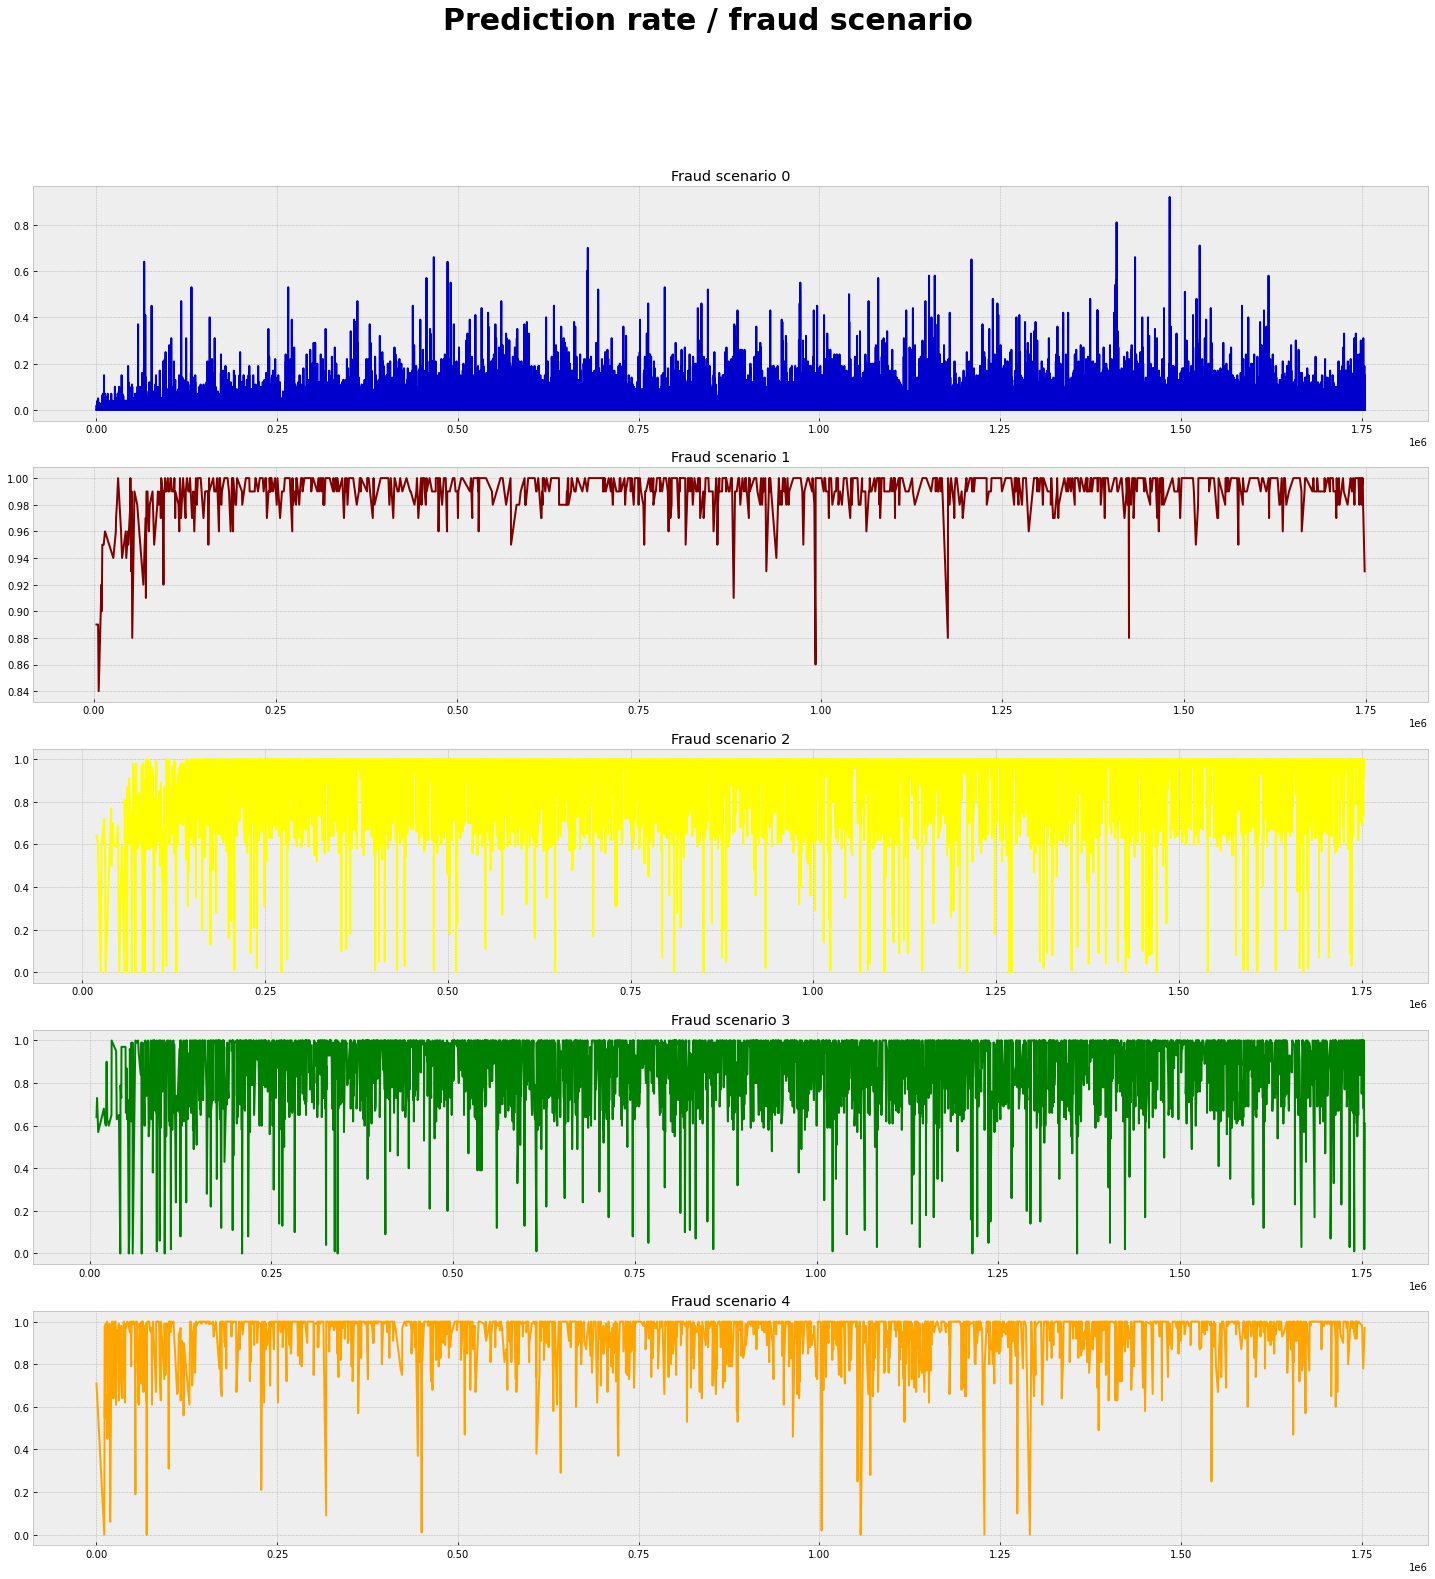

In [93]:
fig, ax=plt.subplots(5,1,figsize=(25, 25))
mplstyle.use('bmh')
fig.suptitle("Prediction rate / fraud scenario", fontsize=30, fontweight='bold')
ax[0].plot(res_scn_0.index, res_scn_0.prediction_rate, color = "mediumblue")
ax[1].plot(res_scn_1.index, res_scn_1.prediction_rate,color = "maroon")
ax[2].plot(res_scn_2.index, res_scn_2.prediction_rate,color = "yellow")
ax[3].plot(res_scn_3.index, res_scn_3.prediction_rate,color = "green")
ax[4].plot(res_scn_4.index, res_scn_4.prediction_rate,color ="orange")

ax[0].title.set_text("Fraud scenario 0")
ax[1].title.set_text("Fraud scenario 1")
ax[2].title.set_text("Fraud scenario 2")
ax[3].title.set_text("Fraud scenario 3")
ax[4].title.set_text("Fraud scenario 4")

plt.show()

Looking for fraud scenario

In [35]:
X=transactions_df[['TX_AMOUNT', 'is_monday', 'is_tuesday', 'is_wednesday',
       'is_thursday', 'is_friday', 'is_saturday', 'is_sunday', 'hour_1_4',
       'hour_2_4', 'hour_3_4', 'hour_4_4', 'average_tx_last1days',
       'tx_count_over_last1days', 'average_tx_last7days',
       'tx_count_over_last7days', 'average_tx_last30days',
       'tx_count_over_last30days','average_terminal_fraud_rate_last15days',
       'average_terminal_fraud_rate_last30days']]  # Features
y=transactions_df['TX_FRAUD_SCENARIO'] 

In [36]:
%time X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

CPU times: user 587 ms, sys: 179 ms, total: 766 ms
Wall time: 876 ms


In [37]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)

#Train the model using the training sets y_pred=clf.predict(X_test)
%time clf.fit(X_train,y_train)

%time y_pred=clf.predict(X_test)

CPU times: user 10min 8s, sys: 8.94 s, total: 10min 17s
Wall time: 1min 46s
CPU times: user 2.8 s, sys: 146 ms, total: 2.95 s
Wall time: 532 ms


In [38]:
# Model Accuracy, how often is the classifier correct?
%time print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9976056916130798
CPU times: user 4.79 ms, sys: 2.34 ms, total: 7.13 ms
Wall time: 5.52 ms


In [39]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

average_terminal_fraud_rate_last15days    0.325951
average_terminal_fraud_rate_last30days    0.186445
TX_AMOUNT                                 0.177161
average_tx_last1days                      0.099103
average_tx_last7days                      0.068261
average_tx_last30days                     0.058119
tx_count_over_last30days                  0.024667
tx_count_over_last7days                   0.020264
tx_count_over_last1days                   0.013340
hour_2_4                                  0.003048
hour_3_4                                  0.003036
hour_1_4                                  0.002566
is_monday                                 0.002415
is_tuesday                                0.002379
is_wednesday                              0.002349
is_thursday                               0.002322
is_saturday                               0.002251
is_sunday                                 0.002225
is_friday                                 0.002202
hour_4_4                       

No handles with labels found to put in legend.


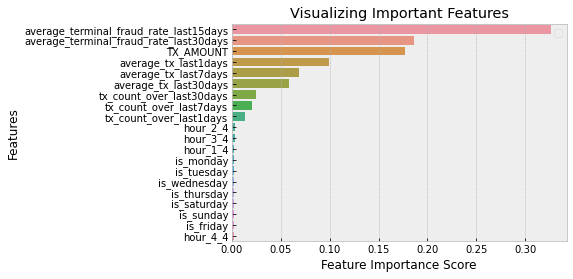

In [40]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()